In [157]:
import cPickle, pupil
from pylab import *
import seaborn as sns
import patsy_transforms as pt
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')
# Load data from all subs
def get_data(sub):
    data = cPickle.load(open(sub+'.pickle'))
    events, messages = data['events'], data['messages']
    events = events.reset_index()
    del events['level_0']
    del events['level_1']
    events.rename(columns={'level_2':'sample_time'}, inplace=True)
    events['sample_time'] = events.sample_time.astype(int)
    events['subject'] = sub
    events.set_index(['session', 'block', 'subject', 'sample_time'], inplace=True)    
    messages.feedback[messages.feedback==0] = -1
    messages['subject'] = sub
    messages = messages.reset_index()
    del messages['level_0']
    del messages['level_1']
    del messages['level_2']
    messages.set_index(['session', 'block', 'subject', 'trial'], inplace=True)    
    return events, messages

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
events, messages = [], []
for sub in ['s01', 's02', 's03', 's04', 's05']:
    print sub
    e, m = get_data(sub)
    e,m = pupil.prepare_glm_regressors(e, m)
    events.append(e)
    messages.append(m)

events = pd.concat(events)
messages = pd.concat(messages)

s01
[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']
s02
[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']
s03
[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']
s04
[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']
s05
[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']


/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [224]:
import pupil
yI, ydtI, ydnI = pupil.IRF_pupil()
IRFS = [yI/yI.std(), ydnI/ydnI.std(), ydtI/ydtI.std()]
yIe, ydtIe, ydnIe = pupil.IRF_pupil(tmax=0.25, n=1)#tmax=.25, n=8)
IRFSe = [yIe, ydtIe, ydnIe]

In [226]:
model = '''
pafilt ~   
     pt.Z(left_gx) +pt.Z(left_gy) +
     pt.MF(pt.Z(left_gx), IRFS) + 
     pt.MF(pt.Z(left_gy), IRFS) + 
     pt.MF(blink, IRFS) +
     pt.MF(pt.Z(pt.dt(left_gx)), IRFS) + 
     pt.MF(pt.Z(pt.dt(left_gy)), IRFS) +
     
     pt.MF(ref, func=IRFS) +  
     pt.MF(contrast, func=IRFS) +
     pt.MF(pt.Z(pt.dt(contrast)), func=IRFS) +
     
     pt.MF(decramp21, IRFS) +
     pt.MF(decramp22, IRFS) +
     pt.MF(decramp23, IRFS) +
     pt.MF(decramp24, IRFS) +

     pt.MF(dec_start, IRFS) +
     pt.MF(decend, IRFS) +     
     
     pt.MF(feedback_offset_pos, IRFS) +
     pt.MF(feedback_offset_neg, IRFS) 
'''

In [228]:
events.groupby?

In [272]:
rsq = []
events['decend'] = events.decision>0
for cond, data in events.groupby(level=['subject', 'session', 'block']):
    m, yh, y, X, res = pupil.eval_model(model, data.reset_index())
    rsq.append((cond, corrcoef(yh.ravel(), y.ravel())[0,1]))

R**2: 0.443646015402
R**2: 0.492936618113
R**2: 0.397547075965
R**2: 0.413005908557
R**2: 0.476713910224
R**2: 0.617245490832
R**2: 0.421236506274
R**2: 0.339380354118
R**2: 0.371283952516
R**2: 0.398717510614
R**2: 0.306714707947
R**2: 0.819522332192
R**2: 0.712226800847
R**2: 0.525674205076
R**2: 0.461508735793
R**2: 0.567679170961
R**2: 0.579039012339
R**2: 0.49102806842
R**2: 0.482946338752
R**2: 0.519082102096
R**2: 0.424110432476
R**2: 0.487160452336
R**2: 0.504398739569
R**2: 0.548983271865
R**2: 0.455187251024
R**2: 0.462066178994
R**2: 0.270052924831
R**2: 0.324988223118
R**2: 0.450999085289
R**2: 0.403364691356
R**2: 0.28429319267
R**2: 0.270052924831
R**2: 0.418320412761
R**2: 0.529524124967
R**2: 0.425378644777
R**2: 0.367657109237
R**2: 0.301496526338
R**2: 0.322145466041
R**2: 0.394182358963
R**2: 0.939978701449
R**2: 0.944407972058
R**2: 0.643804929722
R**2: 0.661556014841
R**2: 0.57471286789
R**2: 0.556635871968
R**2: 0.575977889439
R**2: 0.639526556096
R**2: 0.54613540

(4, 5)
(4, 5)
(5, 5)
(3, 5)
(4, 5)


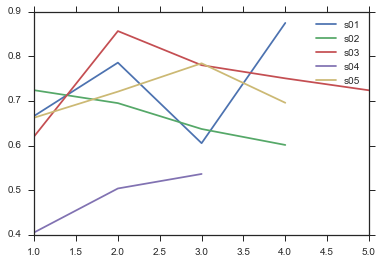

In [299]:
l = pd.DataFrame([list(k)+[v] for k, v in rsq])
colors = sns.color_palette(n_colors=5)
for i, (sub, d) in enumerate(l.groupby(0)):
    print d.pivot(1,2,3).shape
    plot(d.pivot(1,2,3).mean(1), color=colors[i], label=sub)
legend()

In [289]:
sns.color_palette?

In [271]:
import patsy
import patsy_transforms as pt
data = events.loc[2, 4, 's03', slice(None)]
m, yh, y, X, res = pupil.eval_model(model, data.reset_index())



pafilt ~   
     pt.Z(right_gx) +pt.Z(right_gy) +
     pt.MF(pt.Z(right_gx), IRFS) + 
     pt.MF(pt.Z(right_gy), IRFS) + 
     pt.MF(blink, IRFS) +
     pt.MF(pt.Z(pt.dt(right_gx)), IRFS) + 
     pt.MF(pt.Z(pt.dt(right_gy)), IRFS) +
     
     pt.MF(ref, func=IRFS) +  
     pt.MF(contrast, func=IRFS) +
     pt.MF(pt.Z(pt.dt(contrast)), func=IRFS) +
     
     pt.MF(decramp21, IRFS) +
     pt.MF(decramp22, IRFS) +
     pt.MF(decramp23, IRFS) +
     pt.MF(decramp24, IRFS) +

     pt.MF(dec_start, IRFS) +
     pt.MF(decend, IRFS) +     
     
     pt.MF(feedback_offset_pos, IRFS) +
     pt.MF(feedback_offset_neg, IRFS) 

[[ 0.19966422]
 [ 0.20431401]
 [ 0.19138481]
 ..., 
 [-3.52947117]
 [-2.68967257]
 [-1.69307723]]
R**2: 0.944407972058


In [265]:
unique(data.left_gx)[0]

-32768.000000000007

In [264]:
y

DesignMatrix with shape (55898, 1)
    pafilt
   0.19966
   0.20431
   0.19138
   0.14874
   0.07549
  -0.01235
  -0.07856
  -0.06895
   0.07751
   0.40806
   0.93124
   1.60024
   2.31917
   2.97482
   3.47753
   3.78790
   3.91883
   3.91828
   3.84577
   3.75294
   3.67339
   3.62151
   3.59709
   3.59206
   3.59635
   3.60172
   3.60330
   3.59940
   3.59050
   3.57811
  [55868 rows omitted]
  Terms:
    'pafilt' (column 0)
  (to view full data, use np.asarray(this_obj))